<a href="https://colab.research.google.com/github/ananyaarya02/SentiHotel/blob/main/TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
import pandas as pd
import html
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df= pd.read_csv("//content//reviews_for_classification.csv")

In [3]:
df.head()

,name,country,date_time,stars,review_head,review_body
0,xxx xxx,GB,"Updated Apr 4, 2022",5,The best in all that matters,The best in all that matters! It's a great pla...
1,Javier Setovich,US,"Mar 8, 2022",5,Celsius Network ROCKS!,If you are looking for the best #HomeForCrypto...
2,Andrei Franco,VN,"Mar 23, 2022",1,I despise it so much,I despise it so much. Transferring to other wa...
3,Isai Garcia,US,"Feb 23, 2022",1,Worst customer service and worst…,Worst customer service and worst company to de...
4,Tyler McMurray,US,"Mar 22, 2022",5,Celsius is the BEST in Crypto,Celsius is the most transparent and responsive...


In [4]:

#data preprocessing


In [5]:
#dropping columns not contributing directly to sentiment analysis of hotel review
df=df.drop("name",axis=1)

In [6]:
df=df.drop("date_time",axis=1)

In [7]:
df.head()

,country,stars,review_head,review_body
0,GB,5,The best in all that matters,The best in all that matters! It's a great pla...
1,US,5,Celsius Network ROCKS!,If you are looking for the best #HomeForCrypto...
2,VN,1,I despise it so much,I despise it so much. Transferring to other wa...
3,US,1,Worst customer service and worst…,Worst customer service and worst company to de...
4,US,5,Celsius is the BEST in Crypto,Celsius is the most transparent and responsive...


In [8]:
#handling null values
null_values=df.isnull().any()
print(null_values)

country         True
stars          False
review_head    False
review_body    False
dtype: bool


In [9]:
total_null_values=df.isnull().sum()
print(total_null_values)

country        1
stars          0
review_head    0
review_body    0
dtype: int64


In [10]:
#finding most common country among the list of country
most_common_country=df['country'].value_counts().idxmax()
print(most_common_country)

US


In [11]:
#substituting the missing value with the most common country
df['country']=df['country'].fillna('US')


In [12]:
null_values=df.isnull().any().any()
print(null_values)

False


In [13]:
#checking for any html entities
columns_with_entities = ['review_head', 'review_body']
def check_entities_in_column(column):
    return df[column].str.contains('&amp;|&lt;|&gt;', regex=True)

# Dictionary to store rows with entities for each column
rows_with_entities = {}

# Check for HTML entities in specified columns
for col in columns_with_entities:
    entities_detected = check_entities_in_column(col)
    rows_with_entities[col] = df[entities_detected]

# Display rows with detected entities in each column
for col, rows in rows_with_entities.items():
    print(f"Rows with HTML entities in '{col}':")
    print(rows)

Rows with HTML entities in 'review_head':
Empty DataFrame
Columns: [country, stars, review_head, review_body]
Index: []
Rows with HTML entities in 'review_body':
Empty DataFrame
Columns: [country, stars, review_head, review_body]
Index: []


In [14]:
#removing punctuation
import string
string.punctuation

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

df['review_head']= df['review_head'].apply(lambda x:remove_punctuation(x))
df['review_body']= df['review_body'].apply(lambda x:remove_punctuation(x))
df.head()

,country,stars,review_head,review_body
0,GB,5,The best in all that matters,The best in all that matters Its a great platf...
1,US,5,Celsius Network ROCKS,If you are looking for the best HomeForCrypto ...
2,VN,1,I despise it so much,I despise it so much Transferring to other wal...
3,US,1,Worst customer service and worst…,Worst customer service and worst company to de...
4,US,5,Celsius is the BEST in Crypto,Celsius is the most transparent and responsive...


In [15]:
#lowercase conversion
df[['review_head', 'review_body']] = df[['review_head', 'review_body']].apply(lambda x: x.str.lower())

In [16]:
df.head()

,country,stars,review_head,review_body
0,GB,5,the best in all that matters,the best in all that matters its a great platf...
1,US,5,celsius network rocks,if you are looking for the best homeforcrypto ...
2,VN,1,i despise it so much,i despise it so much transferring to other wal...
3,US,1,worst customer service and worst…,worst customer service and worst company to de...
4,US,5,celsius is the best in crypto,celsius is the most transparent and responsive...


In [17]:
#tokenization
import re

def tokenization(text):
    if isinstance(text, str):
        tokens = re.split('\W+', text)
        return tokens
    return []

df[['review_head', 'review_body']] = df[['review_head', 'review_body']].applymap(tokenization)
df.head()


,country,stars,review_head,review_body
0,GB,5,"[the, best, in, all, that, matters]","[the, best, in, all, that, matters, its, a, gr..."
1,US,5,"[celsius, network, rocks]","[if, you, are, looking, for, the, best, homefo..."
2,VN,1,"[i, despise, it, so, much]","[i, despise, it, so, much, transferring, to, o..."
3,US,1,"[worst, customer, service, and, worst, ]","[worst, customer, service, and, worst, company..."
4,US,5,"[celsius, is, the, best, in, crypto]","[celsius, is, the, most, transparent, and, res..."


In [18]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
import nltk
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')
#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
#applying the function
df[['review_head', 'review_body']]= df[['review_head', 'review_body']].apply(lambda x:remove_stopwords(x))



In [20]:
df.head()

,country,stars,review_head,review_body
0,GB,5,"[the, best, in, all, that, matters]","[the, best, in, all, that, matters, its, a, gr..."
1,US,5,"[celsius, network, rocks]","[if, you, are, looking, for, the, best, homefo..."
2,VN,1,"[i, despise, it, so, much]","[i, despise, it, so, much, transferring, to, o..."
3,US,1,"[worst, customer, service, and, worst, ]","[worst, customer, service, and, worst, company..."
4,US,5,"[celsius, is, the, best, in, crypto]","[celsius, is, the, most, transparent, and, res..."


In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [24]:


# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if not recognized

# Function to lemmatize tokens with estimated POS tags
def lemmatize_with_estimated_pos(tokens):
    tagged_tokens = nltk.pos_tag(tokens)  # Estimate POS tags
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(token, pos=pos)
        lemmatized_tokens.append(lemma)
    return lemmatized_tokens

# Assuming 'review_head' and 'review_body' are columns containing tokenized text
for i, row in df.iterrows():
    df.at[i, 'review_head'] = lemmatize_with_estimated_pos(row['review_head'])
    df.at[i, 'review_body'] = lemmatize_with_estimated_pos(row['review_body'])


In [25]:
df.head()

,country,stars,review_head,review_body
0,GB,5,"[the, best, in, all, that, matter]","[the, best, in, all, that, matter, it, a, grea..."
1,US,5,"[celsius, network, rock]","[if, you, be, look, for, the, best, homeforcry..."
2,VN,1,"[i, despise, it, so, much]","[i, despise, it, so, much, transferring, to, o..."
3,US,1,"[worst, customer, service, and, bad, ]","[worst, customer, service, and, bad, company, ..."
4,US,5,"[celsius, be, the, best, in, crypto]","[celsius, be, the, most, transparent, and, res..."


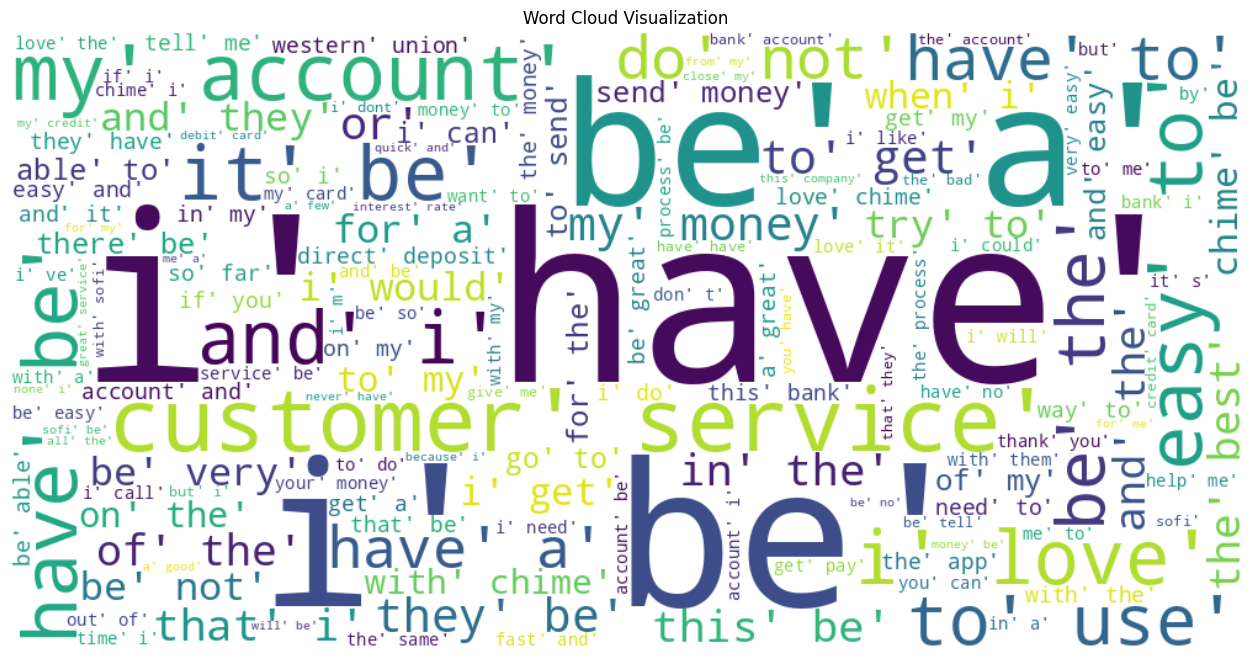

In [26]:
#data visulaization
corpus = df['review_head'].astype(str) + df['review_body'].astype(str)
word_cloud = ' '.join(corpus)
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    min_font_size=10
).generate(word_cloud)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud Visualization')
plt.axis("off")
plt.show()



In [27]:
df['combined_reviews'] = df['review_head'].apply(lambda x: ' '.join(x)) + " " + df['review_body'].apply(lambda x: ' '.join(x))
tfidf_vectorizer = TfidfVectorizer()
train_data = tfidf_vectorizer.fit_transform(df['combined_reviews'])
X = train_data
y = df['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Decision Tree Performance:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)

Decision Tree Performance:
Accuracy: 0.8575329995448339
Precision: 0.8523205444956521
Recall: 0.8575329995448339
F1 Score: 0.8541732766254176


In [29]:
rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=42,criterion='gini', max_features='auto')
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Random Forest Performance:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)

Random Forest Performance:
Accuracy: 0.8582157487482931
Precision: 0.8529622520094915
Recall: 0.8582157487482931
F1 Score: 0.8546059674131247


In [30]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("SVM Performance:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)

SVM Performance:
Accuracy: 0.8582157487482931
Precision: 0.8529622520094915
Recall: 0.8582157487482931
F1 Score: 0.8546059674131247


In [31]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred_dt = knn.predict(X_test)

# Metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("KNN Performance:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)


KNN Performance:
Accuracy: 0.8033682294037323
Precision: 0.81502525997625
Recall: 0.8033682294037323
F1 Score: 0.7862606322059125
